## Project: Computer simulation of a roadblock model of translational control

## rini v0.81 (Main Jupyter notebook)

## Author: Gabin ROUSSEAU

#### Function arguments:

**t = time (number of iterations)**

**a = first site loading rate**

**b = final site unloading rate**

**p = site progression rate**

**L = length of the lattice**

**l = length of a particle passed in the lattice**

**k_on = roadblock binding rate**

**k_off = roadblock unbinding rate**

__l_rb = length of the roadblock__

**B_i = liste of lattice indicies that can be subject to roadblock binding**

---

Exclusive to corini (cooperativity model):

**coop_p = cooperativity "plus", added to k_on when cooperativity is in effect (improves block binding)**

**coop_m = cooperativity "minus", substracted from k_off when cooperativity is in effect (reduces block unbinding)**

**coop_d = cooperativity "distance", for every blockable site, represents the range of sites on either side that will be checked for the presence of another block (resulting in a cooperativity effect).**

---

Model System details:

- rini is a TASEP that follows the Gillespie Algorithm formalism and implements dynamic, targeted roadblock ('defect') binding. 

- The model also includes high customisability in the relative sizes of its dynmaic elements: the model is able to consider particles that are of a different size than the roadblocks (both sizes are customisable in terms of lattice sites).

**State of an individual site** of index i = **Si** (i=1, ..., L)
(With S = 1 if occupied, 0 if empty.)

**pi = progression rate from site i to site i+1** (for i=1,...,L-1) = assumed to be constant here. Should be equal to 1 for phase diagram testing!


Site states will be grouped in the **configuration array C = [S1,..., SL]**

Hopping probabilities will be grouped in the **progression arrary P = [p0,...,pL-1]**


---
_roadblock_ini - v0.81_

# Expressing the way the model computes cooperativity as reactions 
## (can be visualised with Quarto if the reactions don't show up properly)
### Independent block reactions
1 : ${E_{i} ->[k_{on}] B_{i}}$, if 1 $\notin C[i-l_{rb}+1, i+l]$ and 1 $\notin B[i-l_{rb}+1, i+l_{rb}]$

2 : ${B_{i} ->[k_{off}] E_{i}}$

### Cooperativity specific blocking reactions

3 : ${E_{a} + B_{b}->[k_{on} + coop_{p}] B_{a} + B_{b}}$, if 1 $\notin C[a-l_{rb}+1, a+l]$ and 1 $\notin B[a-l_{rb}+1, a+l_{rb}]$

4 : ${B_{a} + B_{b}->[k_{off} - coop_{m}] E_{a} + B_{b}}$

In (3) and (4): b $\in$ [a &pm; ($l_{rb} * coop_{d}$)], and b $\neq$ a

In [1]:
###############################################################################
#
#       roadblocks_in_initiation (rini) v0.81
#                               May 2024
#
#       Author: Gabin Rousseau
#
###############################################################################

#rini dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random


import seaborn as sns
sns.set_theme(style="whitegrid", palette="colorblind")

import pandas as pd
import csv

#rini_AvB dependency
import statistics
import math

#to wrap around iterables to display a progress bar
from tqdm import tqdm

#parameter space computation
from multiprocessing import Pool
import time

In [2]:
#import rinipy functions for the parallel processing component of (co)rini_paramscore
from rinipy import rini_INIvBLOCK as rib
from rinipy import corini_INIvBLOCK as cib

In [2]:
#Core function for the model
def rini(t=500, L=5, l=1, a=0.75, b=0.75, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[]):
    '''
    
    roadblock_ini v0.81
    (rini for short)
    
    DESCRIPTION:
    This is the 0.81 version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation initiation in S. cerevisiae.
    
    -->Runs an inhomogeneous TASEP model of user-defined parameters that allows for a set particle of variable length, to which the exclusion process adapts. Dynamic and targeted roadblock can similarly vary in size.
    Returns a dataset containing for each time point:
    1 - The total number of particles that initiated up to that time point "passed_total". (i.e., passed through the lattice. Not to be confused with loading, where a particle enters the lattice. Named so because we model after the ribosome PIC.)
    2 - The state of each lattice site Si (0 or 1). i = 1 ,..., L
    3 - The lattice-wide density d = number of particles / L. Measured at the end of an iteration.
    
    ARGUMENTS: t, L, l, a, b, p
    t:     number of iterations to run the TASEP model; DEFAULT: t=500
    L:     lattice length;                              DEFAULT: L=5
    l:     particle length;                             DEFAULT: l=1
    a:     rate of loading;                             DEFAULT: a=0.75
    b:     rate of unloading;                           DEFAULT: b=0.75
    p:     rate of scanning (i.e., site hopping);       DEFAULT: p=1
    k_on:  rate of blocking;                            DEFAULT: k_on=0.5
    k_off: rate of unblocking;                          DEFAULT: k_off=0.5
    l_rb:  roadblock length;                            DEFAULT: l_rb=1
    B_i:   blockable lattice index list;                DEFAULT: B_i=[]
    
    
    '''
    
    #set initial variables
    S_start=0
    C=[] #Lattice configuration
    B=[] #Blocking subconfiguration
    B_i.sort() #sort B_i in ascending order
    P=[] #Site hopping rates
    A=[a] #Gillespie propensities
    for i in range(L):
        C.append(S_start)
        B.append(S_start)
        if i < L-1:
            P.append(p)
        if i > 0: #to not overwrite A0=a
            if i < L-1:
                A.append(C[i]*P[i])
            else:
                A.append(0)
                
    for i in B_i:
        A.append(k_on)
        A.append(0) #k_off position
    
    
   
    passed_total=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0], 'density':[0]}
    loc1=0
    #update with all site configurations
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    #update with all block configurations    
    for i in B_i:
        rini_data.update({f'B{i+1}':[0]})
        
    
    #exclusion rule variables
    S_condition_0=C[0:l]
    B_condition_0=C[0:l_rb]
    
    #time tracker to compare against t
    time = 0
    
    #launch model
    while time <= t:
            #Rolling the random numbers for stochasticity
            R=sum(A)
            if R>0:
                r1=np.random.exponential(1/R)
                r2=np.random.uniform(0,1)*R
                time+=r1
                #determining which site is acted upon
                i = 0 #preparing the index of the moved particle
                r = 0.0 #iterative value that serves to pinpoint the index (rmax=R)
                while r < r2:
                    r += A[i]
                    i += 1
                i-=1

                #LOADING
                if i==0 and C[i]==0:
                    C[0]+=1

                #SCANNING
                elif i<L-1 and C[i]==1:
                    C[i]-=1
                    C[i+1]+=1
                    A[i]=0 #reset propensity for the current move

                #UNLOADING
                elif i==L-1 and C[i]==1:
                    C[i]-=1
                    passed_total+=1
                    A[i]=0 #reset propensity for the current move
                    
                    
                #BLOCKING/UNBLOCKING
                elif i>L-1:
                    i-=L
                    #blocking
                    if (i%2)==0:
                        blocked=B_i[int(i/2)]
                        B[blocked]+=1
                        A[i+L+1]=k_off #instantly flag the site as being unblockable
                    #unblocking
                    else:
                        unblocked=B_i[int((i-1)/2)]
                        B[unblocked]-=1
                        A[i+L]=0
    
                else:
                    print(f'An unexpected error happened at time {time}, please check the code because i={i}, A[i]={A[i]} and R={R}.')

                #UPDATING PROPENSITIES FOR THE NEXT ITERATION: LOADING, PARTICLES AND BLOCKS
                particles=[index for index in range(len(C)) if C[index] == 1]

                #load-ready?
                if C[0]==0:
                    if S_condition_0==C[0:l] and B_condition_0==B[0:l_rb]:
                        A[0]=a
                    else:
                        A[0]=0


                #particle check
                for particle in particles:
                    #unload-ready?
                    if particle==L-1:
                        A[particle]=b
                    #scan-ready?                       
                    
                    else: 
                        particle_token=0 #0 means a particle is ahead
                        roadblock_token=0 #0 means a roadblock is ahead
                        #particle checkpoint
                        if particle <= L-l-1: #can it be blocked by another particle?
                            if C[particle+l]==0: #is it not blocked by a particle?
                                particle_token=1
                        else: #can't be blocked by a particle
                            particle_token=1
                            
                                
                        #roadblock checkpoint
                        if particle <= L-l_rb-1: #can it be blocked by a roadblock?
                            if B[particle+l_rb]==0: #is it not blocked by a roadblock?
                                roadblock_token=1
                        else: #can't be blocked by a roadblock
                            roadblock_token=1
                        
                        #token validation
                        if particle_token==1 and roadblock_token==1:
                            A[particle]=P[particle]
                        else:#something is blocking the particle
                            A[particle]=0
                
                #block-ready?
                for block_ii in range(len(B_i)): #loop through block subindicies (index in the configuration index list)
                    block_i=B_i[block_ii] #get the configuration index
                    #restriction rule for blocking to be possible: depends on particle and block length, assumes the tracking site is at the head of all particles/blocks for rule simplicity.
                    
                    if block_i-l_rb+1 >=0: #if a site is place too close to the entry, this value would be negative, this condition takes this scenario into account
                        if 1 not in C[block_i-l_rb+1:block_i+l] and 1 not in B[block_i-l_rb+1:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                    else:
                        if 1 not in C[0:block_i+l] and 1 not in B[0:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                        

                    
                    
            
                #update dataset
                
                if time <= t:
                    rini_data.setdefault('time', []).append(time)
                elif time > t: #force the final time point to be at time=t if t is exceeded at the end of the run
                    rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
            
            else: #break the loop early to avoid errors in case no action is possible (which should only happen if a rate is null)
                #update dataset
                rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
                break

            #END OF ITERATION
            
            
                
        
    return pd.DataFrame(data=rini_data)

In [5]:
#Core function for the model
def corini(t=500, L=5, l=1, a=0.75, b=0.75, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[], coop_p=0.4, coop_m=0.4, coop_d=1):
    '''
    
    roadblock_ini v0.81 
    (rini for short)
    
    DESCRIPTION:
    This is the 0.81 co-operative version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation initiation in S. cerevisiae. As it is "cooperative", it assumes block dynamics are cooperative rather than independent in the base model.
    Variables are the same as rini with three additions.
    coop_p: coop "plus", strength of the coop effect on k_on;   DEFAULT: coop_p = 0.4
    coop_m: coop "minus", strength of the coop effect on k_off; DEFAULT: coop_m = 0.4
    coop_d: coop "distance, area of effect multiplied by l_rb"; DEFAULT: coop_d = 1
    
    '''
    
    #set initial variables
    S_start=0
    C=[] #Lattice configuration
    B=[] #Blocking subconfiguration
    B_i.sort() #sort B_i in ascending order
    P=[] #Site hopping rates
    A=[a] #Gillespie propensities
    for i in range(L):
        C.append(S_start)
        B.append(S_start)
        if i < L-1:
            P.append(p)
        if i > 0: #to not overwrite A0=a
            if i < L-1:
                A.append(C[i]*P[i])
            else:
                A.append(0)
                
    for i in B_i:
        A.append(k_on)
        A.append(0) #k_off position
        A.append(0) #k_on coop
        A.append(0) #k_off coop
    
    #coop parameter limiting
    if k_on+coop_p>1: #coop_p is too high, set it to the allowed maximum
        coop_p=1-k_on
        
    if k_off-coop_m<0: #coop_m is too high, set it to the allowed maximum
        coop_m=k_off
    
    
   
    passed_total=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0], 'density':[0]}
    loc1=0
    #update with all site configurations
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    #update with all block configurations    
    for i in B_i:
        rini_data.update({f'B{i+1}':[0]})
        
    
    #exclusion rule variables
    S_condition_0=C[0:l]
    B_condition_0=C[0:l_rb]
    
    #time tracker to compare against t
    time = 0
    
    #launch model
    while time <= t:
            #Rolling the random numbers for stochasticity
            R=sum(A)
            if R>0:
                r1=np.random.exponential(1/R)
                r2=np.random.uniform(0,1)*R
                time+=r1
                #determining which site is acted upon
                i = 0 #preparing the index of the moved particle
                r = 0.0 #iterative value that serves to pinpoint the index (rmax=R)
                while r < r2:
                    r += A[i]
                    i += 1
                i-=1

                #LOADING
                if i==0 and C[i]==0:
                    C[0]+=1

                #SCANNING
                elif i<L-1 and C[i]==1:
                    C[i]-=1
                    C[i+1]+=1
                    A[i]=0 #reset propensity for the current move

                #UNLOADING
                elif i==L-1 and C[i]==1:
                    C[i]-=1
                    passed_total+=1
                    A[i]=0 #reset propensity for the current move
                    
                    
                #BLOCKING/UNBLOCKING
                elif i>L-1:
                    i-=L
                    #blocking
                    if (i%4)==0:
                        blocked=B_i[int(i/4)]
                        B[blocked]+=1
                        A[i+L]=0
                    #unblocking
                    elif ((i-1)%4)==0:
                        unblocked=B_i[int((i-1)/4)]
                        B[unblocked]-=1
                        A[i+L]=0
                    #coop blocking
                    elif ((i-2)%4)==0:
                        blocked=B_i[int((i-2)/4)]
                        B[blocked]+=1
                        A[i+L]=0
                    #coop unblocking
                    elif ((i-3)%4)==0:
                        unblocked=B_i[int((i-3)/4)]
                        B[unblocked]-=1
                        A[i+L]=0
                else:
                    print(f'An unexpected error happened at time {time}, please check the code because i={i}, A[i]={A[i]} and R={R}.')

                #UPDATING PROPENSITIES FOR THE NEXT ITERATION: LOADING, PARTICLES AND BLOCKS
                particles=[index for index in range(len(C)) if C[index] == 1]
            
                #load-ready?
                if C[0]==0:
                    if S_condition_0==C[0:l] and B_condition_0==B[0:l_rb]:
                        A[0]=a
                    else:
                        A[0]=0


                #particle check
                for particle in particles:
                    #unload-ready?
                    if particle==L-1:
                        A[particle]=b
                    #scan-ready?                       
                    
                    else: 
                        particle_token=0 #0 means a particle is ahead
                        roadblock_token=0 #0 means a roadblock is ahead
                        #particle checkpoint
                        if particle <= L-l-1: #can it be blocked by another particle?
                            if C[particle+l]==0: #is it not blocked by a particle?
                                particle_token=1
                        else: #can't be blocked by a particle
                            particle_token=1
                            
                                
                        #roadblock checkpoint
                        if particle <= L-l_rb-1: #can it be blocked by a roadblock?
                            if B[particle+l_rb]==0: #is it not blocked by a roadblock?
                                roadblock_token=1
                        else: #can't be blocked by a roadblock
                            roadblock_token=1
                        
                        #token validation
                        if particle_token==1 and roadblock_token==1:
                            A[particle]=P[particle]
                        else:#something is blocking the particle
                            A[particle]=0
                
                #block-ready?
                for block_ii in range(len(B_i)): #loop through block subindicies (index in the configuration index list)
                    block_i=B_i[block_ii] #get the configuration index
                    #restriction rule for blocking to be possible: depends on particle and block length, assumes the tracking site is at the head of all particles/blocks for rule simplicity.
                    
                    if block_i-l_rb+1 >=0: #if a site is placed too close to the entry, this value would be negative, this condition takes this scenario into account
                        if 1 not in C[block_i-l_rb+1:block_i+l] and 1 not in B[block_i-l_rb+1:block_i+l_rb]:
                            #COOP-ON EFFECT?
                            if block_i-(l_rb*coop_d) < 0: #this first condition prevents unintended indexing at negative values when calculating cooperativity distance
                                if 1 in B[0:block_i-l_rb+1] or 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                    A[L+(block_ii*4)+2]=k_on+coop_p
                                    A[L+(block_ii*4)]=0
                                else:
                                    A[L+(block_ii*4)]=k_on
                                    A[L+(block_ii*4)+2]=0
                            elif 1 in B[block_i-(l_rb*coop_d):block_i-l_rb+1] or 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                A[L+(block_ii*4)+2]=k_on+coop_p
                                A[L+(block_ii*4)]=0
                            else:
                                A[L+(block_ii*4)]=k_on
                                A[L+(block_ii*4)+2]=0
                        elif B[block_i]==1:
                            #COOP-OFF EFFECT?
                            if block_i-(l_rb*coop_d) < 0:
                                if 1 in B[0:block_i-l_rb+1] or 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                    A[L+(block_ii*4)+3]=k_off-coop_m
                                    A[L+(block_ii*4)+1]=0
                                else:
                                    A[L+(block_ii*4)+1]=k_off
                                    A[L+(block_ii*4)+3]=0
                            
                            elif 1 in B[block_i-(l_rb*coop_d):block_i-l_rb+1] or 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                A[L+(block_ii*4)+3]=k_off-coop_m
                                A[L+(block_ii*4)+1]=0
                            else:
                                A[L+(block_ii*4)+1]=k_off
                                A[L+(block_ii*4)+3]=0
                                
                    else:
                        if 1 not in C[0:block_i+l] and 1 not in B[0:block_i+l_rb]:
                            #COOP-ON EFFECT?
                            if 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                A[L+(block_ii*4)+2]=k_on+coop_p
                                A[L+(block_ii*4)]=0
                            else:
                                A[L+(block_ii*4)]=k_on
                                A[L+(block_ii*4)+2]=0
                        elif B[block_i]==1:
                            #COOP-OFF EFFECT?
                            if 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                A[L+(block_ii*4)+3]=k_off-coop_m
                                A[L+(block_ii*4)+1]=0
                            else:
                                A[L+(block_ii*4)+1]=k_off
                                A[L+(block_ii*4)+3]=0
                        

                    
                    
                #update dataset
                
                if time <= t:
                    rini_data.setdefault('time', []).append(time)
                elif time > t: #force the final time point to be at time=t if t is exceeded at the end of the run
                    rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
            
            else: #break the loop early to avoid errors in case no action is possible (which should only happen if a rate is null)
                #update dataset
                rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
                break

            #END OF ITERATION
            
            
                
        
    return pd.DataFrame(data=rini_data)

    

In [37]:
#Plots the phase diagram
def rini_AvB(t=500, L=5, l=1, p=1,k_on=0.5,k_off=0.5,l_rb=1, tags=False, randomised=False, n=10, B_i=[2]):
    '''
    For rini v0.81
    Plots alpha against beta. By default, plots 3 points expected to fit the respective density phases of TASEP and prints the median lattice occupation density over each point.
    If the 'randomised' argument is set to True, a selectable amount of points (n) will be made for random combinations of a and b.
    '''
    #open data dictionary
    AvB={'alpha':[], 'beta':[], 'mean_d':[], 'd_phase':[], 'expect_d':[]}
    
    if randomised==False:
        #prepare 3 points for LD, HD, and MC scenarios in order
        combi=[[0.25,0.75],[0.75,0.25],[0.75,0.75]]
        for a, b in combi:
            mean_density=statistics.mean(rini(t, L, l, a, b, p, k_on, k_off, l_rb, B_i)['density'])
            AvB.setdefault('alpha', []).append(a)
            AvB.setdefault('beta', []).append(b)
            AvB.setdefault('mean_d', []).append(mean_density)
            #LOW DENSITY EXPECTED
            if a<0.5 and a<b:
                AvB.setdefault('d_phase', []).append('LD')
                AvB.setdefault('expect_d', []).append(a)
                
            #HIGH DENSITY EXPECTED
            elif b<0.5 and b<a:
                AvB.setdefault('d_phase', []).append('HD')
                AvB.setdefault('expect_d', []).append(1-b)
            #MAXIMUM CURRENT EXPECTED
            elif a>0.5 and b>0.5:
                AvB.setdefault('d_phase', []).append('MC')
                AvB.setdefault('expect_d', []).append(0.5)
            
            else:
                AvB.setdefault('d_phase', []).append('NA')
                AvB.setdefault('expect_d', []).append(0)
                
                
            
                        
    elif randomised==True:
        for i in range(n):
            a=round(random.uniform(0.1,1),2)
            b=round(random.uniform(0.1,1),2)
            mean_density=statistics.mean(rini(t, L, l, a, b, p, B_i=B_i)['density'])
            AvB.setdefault('alpha', []).append(a)
            AvB.setdefault('beta', []).append(b)
            AvB.setdefault('mean_d', []).append(mean_density)
            #LOW DENSITY EXPECTED
            if a<0.5 and a<=b:
                AvB.setdefault('d_phase', []).append('LD')
                AvB.setdefault('expect_d', []).append(a)
                
            #HIGH DENSITY EXPECTED
            elif b<0.5 and b<=a:
                AvB.setdefault('d_phase', []).append('HD')
                AvB.setdefault('expect_d', []).append(1-b)
            #MAXIMUM CURRENT EXPECTED
            elif a>=0.5 and b>=0.5:
                AvB.setdefault('d_phase', []).append('MC')
                AvB.setdefault('expect_d', []).append(0.5)
            
            else:
                AvB.setdefault('d_phase', []).append('NA')
                AvB.setdefault('expect_d', []).append(0)
            
        
        
    
    #convert to pandas dF
    AvB_data= pd.DataFrame(data=AvB)
    #plot AvB
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    sns.scatterplot(x='alpha', y='beta', hue='d_phase', data=AvB_data)
    #frame the phases
    plt.plot([0,0.5], [0,0.5], color='r')
    plt.plot([0.5,0.5], [0.5,1.0], color='r')
    plt.plot([0.5,1.0], [0.5,0.5], color='r')
    
    #assign labels to points
    if tags==True:
        for point in range(len(AvB_data['mean_d'])):
            x=AvB_data['alpha'][point]
            y=AvB_data['beta'][point]
            plt.text(x+0.01,y+0.01,f'{point}',size=10)
    plt.xticks(np.arange(0, 1.1, step=0.5))
    plt.yticks(np.arange(0, 1.1, step=0.5))
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.legend(title='Density Phase', labelcolor='mfc',bbox_to_anchor=(1,1))
    
    #plot median vs. expected
    plt.subplot(122)
    plt.plot([0.0,1.0], [0.0,1.0], '--', color='r')
    sns.scatterplot(x='expect_d', y='mean_d', hue='d_phase', data=AvB_data)
    if tags==True:
        for point in range(len(AvB_data['mean_d'])):
            x=AvB_data['expect_d'][point]
            y=AvB_data['mean_d'][point]
            plt.text(x+0.01,y+0.01,f'{point}',size=10)
    plt.xticks(np.arange(0, 1, step=0.1))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.xlabel('Expected bulk density')
    plt.ylabel('Average occupation density')
    plt.legend(title='Density Phase', labelcolor='mfc',bbox_to_anchor=(1,1))
    
    
    plt.tight_layout()
    plt.show();
    
    
    
    
    

In [7]:
#Plots a standardised initiation (protein production proxy) value against the number of blockable sites used
def rini_INIvBLOCK(t=10000, L=100, l=1, a=0.75, b=0.75, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[48, 49, 50], n=10, dataset=False, visual=True, comparison_output=False):
    '''
    For rini v0.81
    
    rini_INIvBLOCK: function to plot a standardised measure of the exit count (represents initiation/protein production) against the number of blocks.
    
    Takes in the usual rini parameters and "timepoint", that defines for which time point of the run average occupancies should be computed; 
    "n" defines how many rini runs will be sampled for the plot.
    "dataset" is a boolean that enables the function to the return the mean_occupancy dataset. (default: False)
    "visual" is a boolean that enables the function to plot the mean occupancies over their lattice sites. (default: True)
    '''
    #open data lists
    repetition=[] #column for repetition IDs
    blocks=[] #columns for blockable site counts
    exits=[] #column for standardised mean exits
      
    blockcount=len(B_i)+1
    
    
    #Launch n runs and calculate standardised mean exits
    exits_zero=[] #tally exits for zero blocks to establish a median standard
    #loop for as many repetitions as required
    for i in tqdm(range(n)):
        #record exit flux for each block scenario
        for ii in range(blockcount):
            
            current_run=rini(t,L,l,a,b,p,k_on,k_off,l_rb,B_i[0:ii])
            
            
           
            repetition.append(i)
            blocks.append(ii)
            current_exits=max(current_run['passed_total'])/t
            exits.append(current_exits)
            if ii == 0:
                exits_zero.append(current_exits)
    median_exits_zero=statistics.median(exits_zero)        
    if median_exits_zero!= 0: #prevent division by zero
        standardised_exits=[x/median_exits_zero for x in exits]   
    else:
        standardised_exits=[x*0 for x in exits]
        print('A division by zero was avoided, standard efficiency = 0 in a point.')  
    
    rini_INIvBLOCK_data=pd.DataFrame(list(zip(repetition, blocks, standardised_exits)), columns = ['repetition_number', 'block_number','initiation'])
    
    if dataset==True:
        return rini_INIvBLOCK_data
        print("Dataset returned.")
        
    if comparison_output==True:
        median1=statistics.median(rini_INIvBLOCK_data['initiation'].loc[rini_INIvBLOCK_data['block_number']==1])
        median2=statistics.median(rini_INIvBLOCK_data['initiation'].loc[rini_INIvBLOCK_data['block_number']==2])
        return (median1, median2)
    
    if visual==True:
        plt.figure(figsize = (12, 4))
        plt.subplot(131)
        sns.boxplot(x='block_number', y='initiation', fill=False, showcaps=False, width=.2, hue='block_number', palette='colorblind', legend=False,data=rini_INIvBLOCK_data.loc[rini_INIvBLOCK_data['block_number']<3])
        #for iii in range(1,blockcount):
            #median_i=statistics.median(rini_INIvBLOCK_data['initiation'].loc[rini_INIvBLOCK_data['block_number']==iii-1])
            #median_ii=statistics.median(rini_INIvBLOCK_data['initiation'].loc[rini_INIvBLOCK_data['block_number']==iii])
            #plt.plot([iii-0.5,iii-0.5], [median_i,median_ii],'--', color='black')
            #plt.text(iii-0.675,median_i+0.001,f'b{iii-1}b{iii} = {median_i-median_ii:.2g}',fontsize=9)
        
        plt.plot([0.75,1.25], [0.959,0.959],'--', color='black')
        plt.plot([1.75,2.25], [0.741,0.741],'--', color='black')
        
        #plt.xticks(np.arange(0, L+2, step=2))
        plt.yticks(np.arange(0, 1.2, step=0.2))
        plt.xlabel('Number of blockable sites')
        plt.ylabel('Initiation efficiency')

        plt.tight_layout()
        plt.show();

In [14]:
#Plots a standardised initiation (protein production proxy) value against the number of blockable sites used
def corini_INIvBLOCK(t=10000, L=100, l=1, a=0.75, b=0.75, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[48, 49, 50],coop_p=0.4, coop_m=0.4, coop_d=1, n=10, dataset=False, visual=True, comparison_output=False):
    '''
    For corini v0.81
    
    rini_INIvBLOCK: function to plot a standardised measure of the exit count (represents initiation/protein production) against the number of blocks.
    
    Takes in the usual rini parameters and "timepoint", that defines for which time point of the run average occupancies should be computed; 
    "n" defines how many rini runs will be sampled for the plot.
    "dataset" is a boolean that enables the function to the return the mean_occupancy dataset. (default: False)
    "visual" is a boolean that enables the function to plot the mean occupancies over their lattice sites. (default: True)
    '''
    #open data lists
    repetition=[] #column for repetition IDs
    blocks=[] #columns for blockable site counts
    exits=[] #column for standardised mean exits
      
    blockcount=len(B_i)+1
    
    
    #Launch n runs and calculate standardised mean exits
    exits_zero=[] #tally exits for zero blocks to establish a median standard
    #loop for as many repetitions as required
    for i in tqdm(range(n)):
        #record exit flux for each block scenario
        for ii in range(blockcount):
            
            current_run=corini(t,L,l,a,b,p,k_on,k_off,l_rb,B_i[0:ii],coop_p,coop_m,coop_d)
            
            
           
            repetition.append(i)
            blocks.append(ii)
            current_exits=max(current_run['passed_total'])/t
            exits.append(current_exits)
            if ii == 0:
                exits_zero.append(current_exits)
    median_exits_zero=statistics.median(exits_zero)
    
    if median_exits_zero!= 0: #prevent division by zero
        standardised_exits=[x/median_exits_zero for x in exits]   
    else:
        standardised_exits=[x*0 for x in exits]
        print('A division by zero was avoided, standard efficiency = 0 in a point.')
        
    rini_INIvBLOCK_data=pd.DataFrame(list(zip(repetition, blocks, standardised_exits)), columns = ['repetition_number', 'block_number','initiation'])
    
    if dataset==True:
        return rini_INIvBLOCK_data
        print("Dataset returned.")
        
    if comparison_output==True:
        median1=statistics.median(rini_INIvBLOCK_data['initiation'].loc[rini_INIvBLOCK_data['block_number']==1])
        median2=statistics.median(rini_INIvBLOCK_data['initiation'].loc[rini_INIvBLOCK_data['block_number']==2])
        return (median1, median2)
    
    if visual==True:
        plt.figure(figsize = (12, 4))
        plt.subplot(131)
        sns.boxplot(x='block_number', y='initiation', fill=False, showcaps=False, width=.2, hue='block_number', palette='colorblind', legend=False,data=rini_INIvBLOCK_data.loc[rini_INIvBLOCK_data['block_number']<3])
        #for iii in range(1,blockcount):
         #   median_i=statistics.median(rini_INIvBLOCK_data['initiation'].loc[rini_INIvBLOCK_data['block_number']==iii-1])
          #  median_ii=statistics.median(rini_INIvBLOCK_data['initiation'].loc[rini_INIvBLOCK_data['block_number']==iii])
           # plt.plot([iii-0.5,iii-0.5], [median_i,median_ii],'--', color='black')
            #plt.text(iii-0.675,median_i+0.001,f'b{iii-1}b{iii} = {median_i-median_ii:.2g}',fontsize=9)
        
        plt.plot([0.75,1.25], [0.959,0.959],'--', color='black')
        plt.plot([1.75,2.25], [0.741,0.741],'--', color='black')
        
        #plt.xticks(np.arange(0, L+2, step=2))
        plt.yticks(np.arange(0, 1.2, step=0.2))
        plt.xlabel('Number of blockable sites')
        plt.ylabel('Initiation efficiency')
        #plt.title(f'Initiation efficiency vs. number of blocks | Sites:{[x+1 for x in B_i]} | Pb = {round(k_on/(k_on+k_off)*100,1)}% | n = {n}')

        plt.tight_layout()
        plt.show();

100%|██████████| 10/10 [00:00<00:00, 17.16it/s]


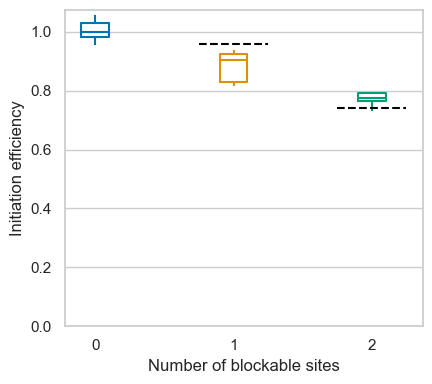

In [12]:
#k_on best inde plot
rini_INIvBLOCK(t=1000, L=5, l=1, a=0.75, b=0.75, p=1, k_on=0.227, k_off=0.5, l_rb=1, B_i=[1, 2, 3], n=10, dataset=False, visual=True, comparison_output=False)

100%|██████████| 10/10 [00:00<00:00, 18.68it/s]


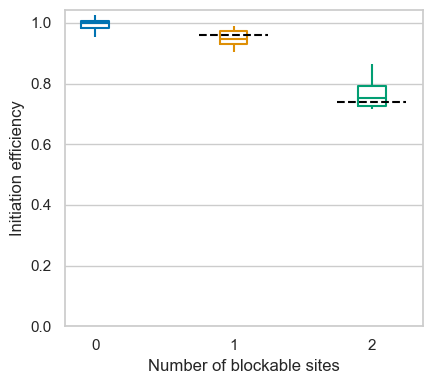

In [28]:
#k_on best coop plot
corini_INIvBLOCK(t=1000, L=5, l=1, a=0.75, b=0.75, p=1, k_on=0.043, k_off=0.5, l_rb=1, B_i=[1, 2, 3],coop_p=0.4, coop_m=0.4, coop_d=1, n=10, dataset=False, visual=True, comparison_output=False)

In [6]:
def rini_paramscore(t=500, L=5, l=1, p=1, l_rb=1, B_i=[1,2,3], n=10, n_ivb=10, visual=False, dataset=True,a=0.75,b=0.75, k_on=None, k_off=0.5):
    '''
    For rini v0.81
    
    rini_paramscore: This function uses parallel processing to quickly parse through n runs of rini via rini_INIvBLOCK (comparison_output set to True) in order to calculate similarities in the model's output to experimental data per semi-random parameter set.
    A score of similarity S is assigned as the mean of s1 and s2, individual scores for the median standardised initiation efficiency at 1 and 2 block sites respectively.
    
    Input: t=1000, L=5, l=1, p=1, l_rb=1, B_i=[1,2,3], n, visual=False, dataset=True // specify the default parameters that won't be randomised i.e. time and lattice settings, n as the number of parameter sets to run through, visual dictates whether a plot of the output is to be generated, dataset dictates whether the output is returned.
    Contents: the function should generate a list of rini_INIvBLOCK argument tuples of length n where the rates a, b, k_on, k_off and coop parameters are randomised in a way fitting the parameters' boundaries (rates vary from 0 to 1 uniformly, coop_d varies between 1 and 2?). This can be passed onto a multiprocesses Pool class object as a starmap, allowing for parallel processing of the runs required. The pool processing would return a list of results which can be used to finalise the output.
    Output: a dataset showing for each parameter set: its ID, all of the parameters, a score of similarity to experimental data S: the mean of the individual similarity scores s1 and s2 1-|1-(model/experimental)| for the 1 site and 2 site values: the closer the score is to 1, the better the model result.
   
    '''
    arguments=[] #list of parameter sets for parallel processing
    
    #prepare lists for the dataset
    ID=[]
    
    time=[]
    lattice=[]
    particle_len=[]
    roadblock_len=[]
    alpha=[]
    beta=[]
    hop_rate=[]
    block_binding=[]
    block_unbinding=[]
    sampling=[]
    
    m1=[]
    m2=[]
    s1=[]
    s2=[]
    S=[]
    
    a_random=False
    b_random=False
    k_on_random=False
    k_off_random=False

    
    if a==None:
        a_random=True
    if b==None:
        b_random=True
    if k_on==None:
        k_on_random=True
    if k_off==None:
        k_off_random=True
    
   
    print('Loading parameters...')
    for i in range(n):
        if a_random==True:
            a=round(random.uniform(0,1),3)
        if b_random==True:
            b=round(random.uniform(0,1),3)
        if k_on_random==True:
            k_on=round(random.uniform(0,1),3)
        if k_off_random==True:
            k_off=round(random.uniform(0,1),3)
        
        
        arguments.append((t, L, l, a, b, p, k_on, k_off, l_rb, B_i, n_ivb, False, False, True))
        
        ID.append(i)
    
        time.append(t)
        lattice.append(L)
        particle_len.append(l)
        roadblock_len.append(l_rb)
        alpha.append(a)
        beta.append(b)
        hop_rate.append(p)
        block_binding.append(k_on)
        block_unbinding.append(k_off)
        sampling.append(n_ivb)
    print('Finished loading parameters, beginning parallel processing.')
    
    results=[]
    if __name__ == '__main__':
        with Pool() as pool:
            results=pool.starmap(rib, arguments)
            
    print('Finished parallel processing, beginning results interpretation.')
    
    for result in results:
        
        #Get the medians for 1-site and 2-site scenarios
        m1.append(round(result[0], 4))
        m2.append(round(result[1], 4))
        
        #calculate absolute error from experimental data and the root mean square of these errors 
        one_site= result[0] - 0.959
        two_sites= result[1] - 0.741
        score=math.sqrt((one_site**2+two_sites**2)/2)
        s1.append(round(one_site, 4))
        s2.append(round(two_sites, 4))
        S.append(round(score,4))
    
    paramspace=pd.DataFrame(list(zip(ID,m1,m2,s1,s2,S,time,lattice,particle_len,roadblock_len,alpha,beta,hop_rate,block_binding,block_unbinding,sampling)), columns = ['ID','median_1s','median_2s','s1','s2','S','time','lattice','particle_length','roadblock_length','alpha','beta','p','block_binding','block_unbinding','n'])
    
    if dataset==True:
        return paramspace
        print('Dataset returned.')

    
    if visual==True:
        plt.figure(figsize = (12, 4))
        plt.subplot(131)
        sns.scatterplot(x='s1', y='s2', hue='block_binding',palette="ch:r=-.2,d=.3_r",data=paramspace)
        
        plt.xticks(np.arange(0, 1.2, step=0.2))
        plt.yticks(np.arange(0, 1.2, step=0.2))
        plt.xlabel('1 site')
        plt.ylabel('2 sites')
        plt.title('Parameter space showing model/experimental absolute error scores (INDEPENDENCE)')

        plt.tight_layout()
        plt.show();
        
    
        
    
    
    
    
    
    
        

In [7]:
def corini_paramscore(t=500, L=5, l=1, p=1, l_rb=1, B_i=[1,2,3], n=10, n_ivb=10, visual=False, dataset=True, a=0.75,b=0.75, k_on=None, k_off=0.5,coop_p=0.4,coop_m=0.4,coop_d=1):
    '''
    For corini v0.81
    
    rini_paramscore: This function uses parallel processing to quickly parse through n runs of corini via corini_INIvBLOCK (comparison_output set to True) in order to calculate similarities in the model's output to experimental data per semi-random parameter set.
    A score of similarity S is assigned as the mean of s1 and s2, individual scores for the median standardised initiation efficiency at 1 and 2 block sites respectively.
    
    Input: t=1000, L=5, l=1, p=1, l_rb=1, B_i=[1,2,3], n, visual=False, dataset=True // specify the default parameters that won't be randomised i.e. time and lattice settings, n as the number of parameter sets to run through, visual dictates whether a plot of the output is to be generated, dataset dictates whether the output is returned.
    Contents: the function should generate a list of rini_INIvBLOCK argument tuples of length n where the rates a, b, k_on, k_off and coop parameters are randomised in a way fitting the parameters' boundaries (rates vary from 0 to 1 uniformly, coop_d varies between 1 and 2?). This can be passed onto a multiprocesses Pool class object as a starmap, allowing for parallel processing of the runs required. The pool processing would return a list of results which can be used to finalise the output.
    Output: a dataset showing for each parameter set: its ID, all of the parameters, a score of similarity to experimental data S: the mean of the individual similarity scores s1 and s2 1-|1-(model/experimental)| for the 1 site and 2 site values: the closer the score is to 1, the better the model result.
   
    '''
    arguments=[] #list of parameter sets for parallel processing
    
    #prepare lists for the dataset
    ID=[]
    
    time=[]
    lattice=[]
    particle_len=[]
    roadblock_len=[]
    alpha=[]
    beta=[]
    hop_rate=[]
    block_binding=[]
    block_unbinding=[]
    coop_recruit=[]
    coop_stability=[]
    coop_area=[]
    sampling=[]
    
    m1=[]
    m2=[]
    s1=[]
    s2=[]
    S=[]
    
    a_random=False
    b_random=False
    k_on_random=False
    k_off_random=False
    coop_p_random=False
    coop_m_random=False
    coop_d_random=False
    
    if a==None:
        a_random=True
    if b==None:
        b_random=True
    if k_on==None:
        k_on_random=True
    if k_off==None:
        k_off_random=True
    if coop_p==None:
        coop_p_random=True
    if coop_m==None:
        coop_m_random=True
    if coop_d==None:
        coop_d_random=True
    
    print('Loading parameters...')
    for i in range(n):
        if a_random==True:
            a=round(random.uniform(0,1),3)
        if b_random==True:
            b=round(random.uniform(0,1),3)
        if k_on_random==True:
            k_on=round(random.uniform(0,1),3)
        if k_off_random==True:
            k_off=round(random.uniform(0,1),3)
        if coop_p_random==True:
            coop_p=round(random.uniform(0,1),3)
        if coop_m_random==True:
            coop_m=round(random.uniform(0,1),3)
        if coop_p_random==True:
            coop_d=random.randint(1,2)
        
        arguments.append((t, L, l, a, b, p, k_on, k_off, l_rb, B_i, coop_p, coop_m, coop_d, n_ivb, False, False, True))
        
        ID.append(i)
    
        time.append(t)
        lattice.append(L)
        particle_len.append(l)
        roadblock_len.append(l_rb)
        alpha.append(a)
        beta.append(b)
        hop_rate.append(p)
        block_binding.append(k_on)
        block_unbinding.append(k_off)
        coop_recruit.append(coop_p)
        coop_stability.append(coop_m)
        coop_area.append(coop_d)
        sampling.append(n_ivb)
    print('Finished loading parameters, beginning parallel processing.')
    
    results=[]
    if __name__ == '__main__':
        with Pool() as pool:
            results=pool.starmap(cib, arguments)
            
    print('Finished parallel processing, beginning results interpretation.')
    
    for result in results:
        
        #Get the medians for 1-site and 2-site scenarios
        m1.append(round(result[0], 4))
        m2.append(round(result[1], 4))
        
        #calculate absolute error from experimental data and the root mean square of these errors 
        one_site= result[0] - 0.959 
        two_sites= result[1] - 0.741
        score=math.sqrt((one_site**2+two_sites**2)/2)
        s1.append(round(one_site, 4))
        s2.append(round(two_sites, 4))
        S.append(round(score,4))
    
    paramspace=pd.DataFrame(list(zip(ID,m1,m2,s1,s2,S,time,lattice,particle_len,roadblock_len,alpha,beta,hop_rate,block_binding,block_unbinding,coop_recruit,coop_stability,coop_area,sampling)), columns = ['ID','median_1s','median_2s','s1','s2','S','time','lattice','particle_length','roadblock_length','alpha','beta','p','block_binding','block_unbinding','coop_recruit','coop_stability','coop_area','n'])
    
    
                        
    if dataset==True:
        return paramspace
        print('Dataset returned.')
          
    if visual==True:
        
        plt.figure(figsize = (12, 4))
        plt.subplot(131)
        sns.scatterplot(x='s1', y='s2', hue='block_binding',palette="ch:r=-.2,d=.3_r",data=paramspace)
        
        
        plt.xticks(np.arange(0, 1.2, step=0.2))
        plt.yticks(np.arange(0, 1.2, step=0.2))
        plt.xlabel('1 site')
        plt.ylabel('2 sites')
        plt.title('Parameter space showing model/experimental absolute error scores (COOPERATION)')

        plt.tight_layout()
        plt.show();
        
    
        
    
    
    
    
    
    
        
    

In [25]:
#extra function to plot a saved rini_paramscore dataset with all rates randomised
def plot_paramulti(dataset):
    plt.figure(figsize = (12, 4))
    plt.subplot(131)
    sns.scatterplot(x='s1', y='s2', hue='block_binding',palette="ch:r=-.2,d=.3_r",linewidth=0,alpha=.5,data=dataset)
    
    plt.plot([-0.6,0.4], [0,0],'--', color='red')
    plt.plot([0,0], [-0.8,0.4],'--', color='red')
        
        
    plt.xticks(np.arange(-0.6, 0.41, step=0.2))
    plt.yticks(np.arange(-0.8, 0.41, step=0.2))
    plt.xlabel('1 block site')
    plt.ylabel('2 block sites')
    plt.title('Model-Experiment error with different block site numbers')

    plt.tight_layout()
    plt.show();
       

In [9]:
#Generate and save a parameter space exploration run from rini
parameters_inde=rini_paramscore(n=1000,visual=False,dataset=True)

Loading parameters...
Finished loading parameters, beginning parallel processing.
Finished parallel processing, beginning results interpretation.


In [10]:
#Generate and save a parameter space exploration run from corini
parameters_coop=corini_paramscore(n=1000,visual=False,dataset=True)

Loading parameters...
Finished loading parameters, beginning parallel processing.
Finished parallel processing, beginning results interpretation.


In [24]:
#parameters_inde, get the best 5
best5_inde=parameters_inde.sort_values(by=['S']).head(5)
best5_inde.to_csv(path_or_buf='INSERT PATH')

In [23]:
#parameters_coop, get the best 5
best5_coop=parameters_coop.sort_values(by=['S']).head(5)
best5_coop.to_csv(path_or_buf='INSERT PATH')


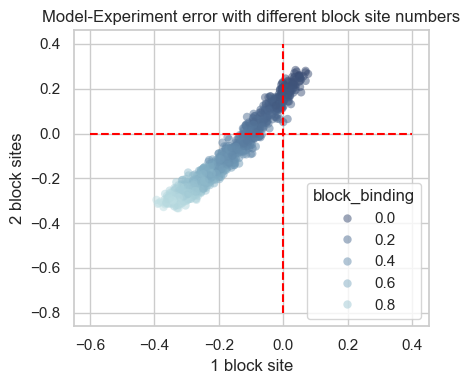

In [27]:
#parameters_coop, plot (multi)
plot_paramulti(parameters_inde)

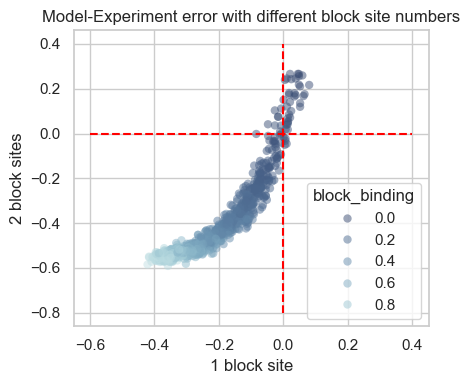

In [26]:
#parameters_coop, plot (multi)
plot_paramulti(parameters_coop)